In [1]:
!pip install pmdarima

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings

In [2]:
from math import sqrt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [3]:
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('../../data/sensor1.csv')

In [5]:
df = df.dropna()

In [6]:
units_dict = {}

for col in df.columns[1:]:
    values = []
    units = set()
    for val in df[col]:
        value, unit = val.split()
        values.append(value)
        units.add(unit)
    new_col_name = f"{col} ({units.pop()})"
    df.rename(columns={col: new_col_name}, inplace=True)
    df[new_col_name] = pd.to_numeric(values)
    units_dict[col] = units

In [7]:
df['Time'] = pd.to_datetime(df['Time'])

In [8]:
df.index = df['Time']
df.drop(columns=['Time'], inplace=True)

In [9]:
df = df.sort_index()

In [10]:
humidity = df["Humidity (%H)"]

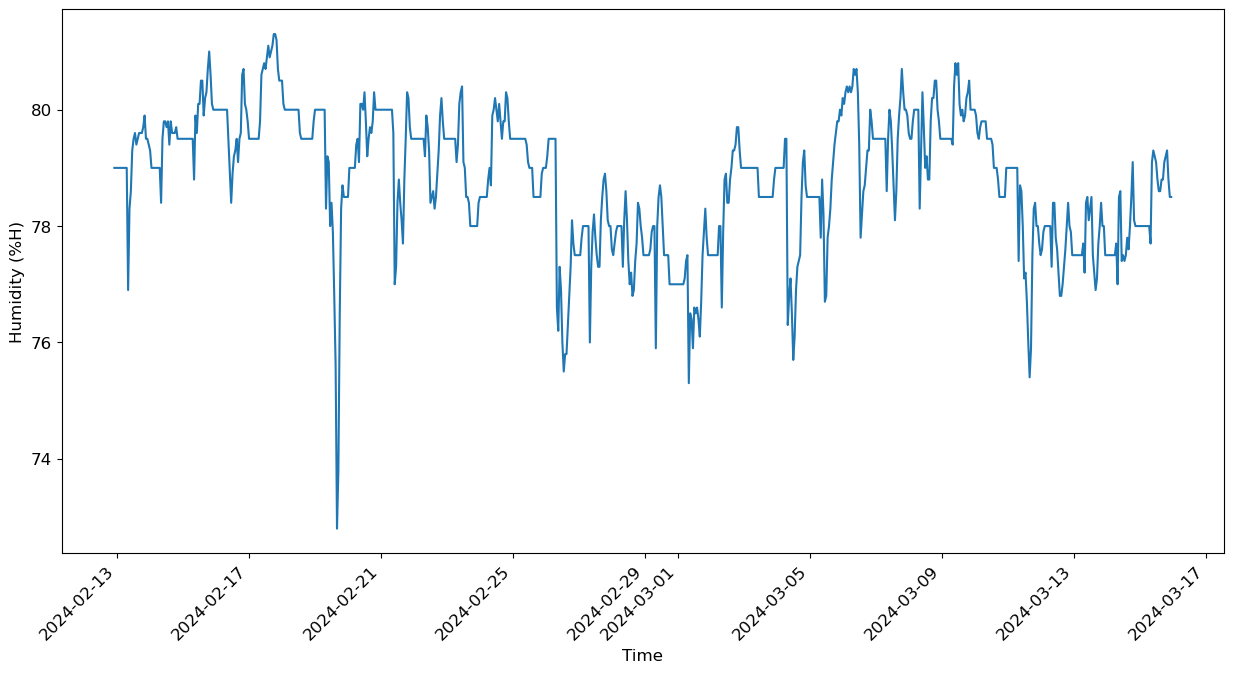

In [11]:
humidity.plot(y='Humidity (%H)', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Humidity (%H)', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Create training and testing datasets

In [12]:
train_size = int(0.8 * len(df))

In [13]:
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

In [14]:
train_start_dt = train_df.index[0]
test_start_dt = test_df.index[0]

In [15]:
train_start_dt, test_start_dt

(Timestamp('2024-02-12 22:00:00'), Timestamp('2024-03-09 14:00:00'))

In [16]:
df

CO2 (ppm)  Humidity (%H)  PM10 (μg/m³)  PM2.5 (μg/m³)  \
Time                                                                         
2024-02-12 22:00:00        456           79.0          5.60           5.60   
2024-02-12 23:00:00        456           79.0          5.25           5.13   
2024-02-13 00:00:00        456           79.0          6.00           5.89   
2024-02-13 01:00:00        450           79.0          6.44           6.33   
2024-02-13 02:00:00        447           79.0          6.25           5.88   
...                        ...            ...           ...            ...   
2024-03-15 19:00:00        559           79.2         18.30          18.00   
2024-03-15 20:00:00        564           79.3         18.80          17.70   
2024-03-15 21:00:00        569           78.8         17.50          16.20   
2024-03-15 22:00:00        566           78.5         17.80          17.50   
2024-03-15 23:00:00        569           78.5         17.00          17.00   

                     Temperature (°C)  TVOC (ppm)  
Time                                               
2024-02-12 22:00:00              24.0       0.642  
2024-02-12 23:00:00              24.1       0.711  
2024-02-13 00:00:00              24.2       0.744  
2024-02-13 01:00:00              24.2       0.759  
2024-02-13 02:00:00              24.3       0.775  
...                               ...         ...  
2024-03-15 19:00:00              23.0       0.590  
2024-03-15 20:00:00              23.3       0.597  
2024-03-15 21:00:00              23.6       0.613  
2024-03-15 22:00:00              23.8       0.662  
2024-03-15 23:00:00              23.9       0.660  

[768 rows x 6 columns]

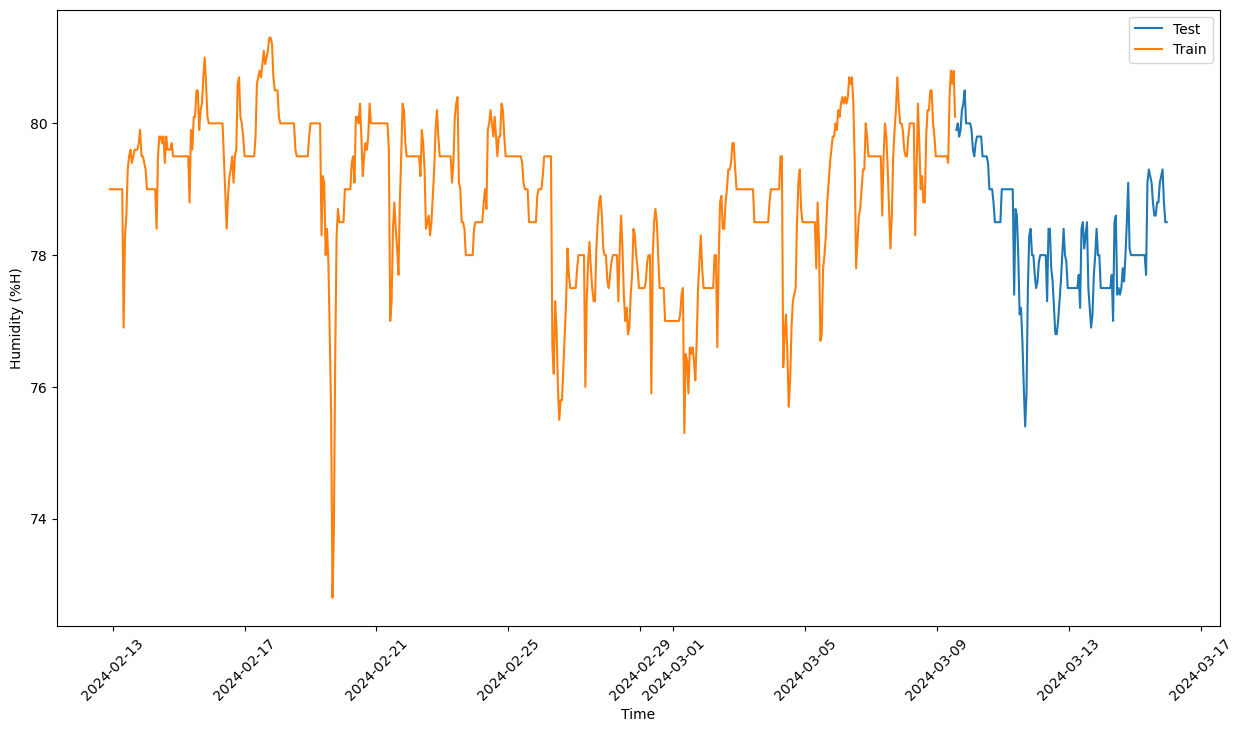

In [17]:
test_humidity = df[df.index >= test_start_dt]["Humidity (%H)"]
train_humidity = df[(df.index < test_start_dt) & (df.index >= train_start_dt)]["Humidity (%H)"]

plt.figure(figsize=(15, 8))
plt.plot(test_humidity.index, test_humidity.values, label='Test')

plt.plot(train_humidity.index, train_humidity.values, label='Train')

plt.xlabel('Time')
plt.ylabel('Humidity (%H)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Data preparation

In [18]:
train_humidity_reshaped = train_humidity.values.reshape(-1, 1)
test_humidity_reshaped = test_humidity.values.reshape(-1, 1)

In [19]:
print("Training data shape: ", train_humidity_reshaped.shape)
print("Test data shape: ", test_humidity_reshaped.shape)

Training data shape:  (614, 1)
Test data shape:  (154, 1)


In [20]:
scaler = MinMaxScaler()
train_humidity_scaled = scaler.fit_transform(train_humidity_reshaped)
train_humidity_scaled = pd.DataFrame(train_humidity_scaled.flatten(), index=train_humidity.index, columns=["Humidity (%H)"])
train_humidity_scaled.head(10)

Humidity (%H)
Time                              
2024-02-12 22:00:00       0.729412
2024-02-12 23:00:00       0.729412
2024-02-13 00:00:00       0.729412
2024-02-13 01:00:00       0.729412
2024-02-13 02:00:00       0.729412
2024-02-13 03:00:00       0.729412
2024-02-13 04:00:00       0.729412
2024-02-13 05:00:00       0.729412
2024-02-13 06:00:00       0.729412
2024-02-13 07:00:00       0.729412

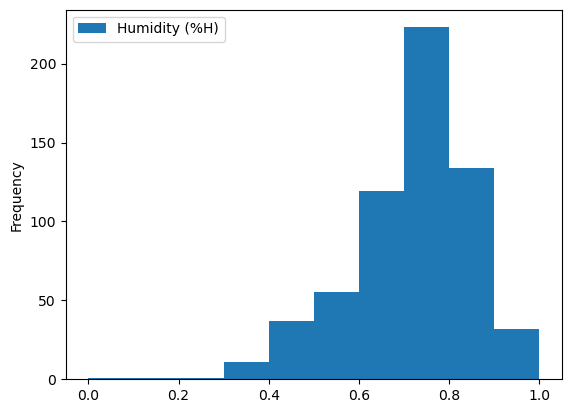

In [21]:
train_humidity_scaled.plot.hist(bins=10)
plt.show()

In [22]:
test_humidity_scaled = scaler.fit_transform(test_humidity_reshaped)
test_humidity_scaled = pd.DataFrame(test_humidity_scaled.flatten(), index=test_humidity.index, columns=["Humidity (%H)"])
test_humidity_scaled.head(10)

Humidity (%H)
Time                              
2024-03-09 14:00:00       0.882353
2024-03-09 15:00:00       0.901961
2024-03-09 16:00:00       0.862745
2024-03-09 17:00:00       0.882353
2024-03-09 18:00:00       0.941176
2024-03-09 19:00:00       0.960784
2024-03-09 20:00:00       1.000000
2024-03-09 21:00:00       0.901961
2024-03-09 22:00:00       0.901961
2024-03-09 23:00:00       0.901961

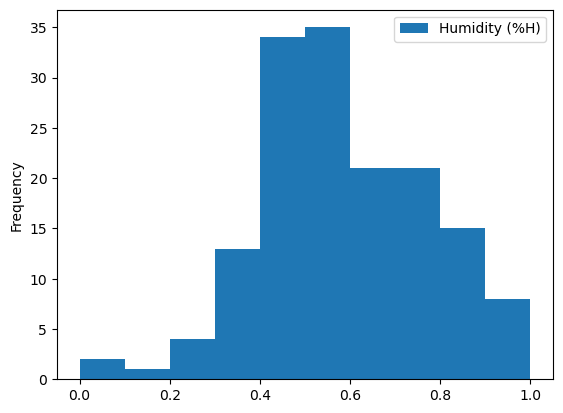

In [23]:
test_humidity_scaled.plot.hist(bins=10)
plt.show()

In [24]:
HORIZON_HUMIDITY = 1

In [25]:
stepwise_fit_humidity = auto_arima(train_humidity_scaled, trace=True, suppress_warnings=True)
stepwise_fit_humidity.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1744.309, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1706.906, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1705.480, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1705.757, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1708.898, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1744.462, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1722.733, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1736.000, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1742.432, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1725.675, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1741.719, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1740.974, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1746.406, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-1724.719, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  614
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 878.409
Date:                Fri, 15 Mar 2024   AIC                          -1746.817
Time:                        23:22:18   BIC                          -1724.725
Sample:                             0   HQIC                         -1738.226
                                - 614                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8299      0.040     20.630      0.000       0.751       0.909
ma.L1         -0.8494      0.046    -18.319      0.000      -0.940      -0.759
ma.L2         -0.2008      0.039     -5.142      0.000      -0.277      -0.124
ma.L3          0.0823      0.044      1.861      0.063      -0.004       0.169
sigma2         0.0033    7.6e-05     43.784      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3509.38
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -1.85
Prob(H) (two-sided):                  0.61   Kurtosis:                        14.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
order_humidity = (1,1,3)

In [27]:
model_humidity =  ARIMA(endog=train_humidity_scaled, order=order_humidity)
result_humidity = model_humidity.fit()

print(result_humidity.summary())

                               SARIMAX Results                                
Dep. Variable:          Humidity (%H)   No. Observations:                  614
Model:                 ARIMA(1, 1, 3)   Log Likelihood                 878.409
Date:                Fri, 15 Mar 2024   AIC                          -1746.817
Time:                        23:22:28   BIC                          -1724.725
Sample:                             0   HQIC                         -1738.226
                                - 614                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8299      0.040     20.630      0.000       0.751       0.909
ma.L1         -0.8494      0.046    -18.319      0.000      -0.940      -0.759
ma.L2         -0.2008      0.039     -5.142      0.0

Walk-forward validation

Create a test data point for each HORIZON.<br>
Shift the data horizontally according to its horizon point.

In [28]:
test_humidity_shifted = test_humidity_scaled.copy()

for t in range(1, HORIZON_HUMIDITY):
    test_humidity_shifted["Humidity (%H)+" + str(t)] = test_humidity_shifted["Humidity (%H)"].shift(-t, freq='H')
    
test_humidity_shifted = test_humidity_shifted.dropna(how='any')
test_humidity_shifted.head()

Humidity (%H)
Time                              
2024-03-09 14:00:00       0.882353
2024-03-09 15:00:00       0.901961
2024-03-09 16:00:00       0.862745
2024-03-09 17:00:00       0.882353
2024-03-09 18:00:00       0.941176

Make predictions on the test data using a sliding window approach in a loop the size of the test data length.

In [29]:
stepwise_fit_humidity_test = auto_arima(test_humidity_scaled, trace=True, suppress_warnings=True)
stepwise_fit_humidity_test.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-323.271, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-319.924, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-318.002, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-318.027, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-321.855, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-325.374, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-319.276, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-325.360, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-320.015, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-321.400, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-325.552, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-318.202, Time=0.01 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-323.724, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-316.915, Time=0.01 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  154
Model:               SARIMAX(2, 1, 1)   Log Likelihood                 167.552
Date:                Fri, 15 Mar 2024   AIC                           -327.104
Time:                        23:22:33   BIC                           -314.982
Sample:                    03-09-2024   HQIC                          -322.180
                         - 03-15-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7809      0.126      6.185      0.000       0.533       1.028
ar.L2         -0.1261      0.085     -1.486      0.137      -0.292       0.040
ma.L1         -0.8690      0.107     -8.106      0.000      -1.079      -0.659
sigma2         0.0065      0.000     13.623      0.000       0.006       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                81.84
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                             0.29
Prob(H) (two-sided):                  0.65   Kurtosis:                         6.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
test_humidity_shifted

Humidity (%H)
Time                              
2024-03-09 14:00:00       0.882353
2024-03-09 15:00:00       0.901961
2024-03-09 16:00:00       0.862745
2024-03-09 17:00:00       0.882353
2024-03-09 18:00:00       0.941176
...                            ...
2024-03-15 19:00:00       0.745098
2024-03-15 20:00:00       0.764706
2024-03-15 21:00:00       0.666667
2024-03-15 22:00:00       0.607843
2024-03-15 23:00:00       0.607843

[154 rows x 1 columns]

In [40]:
%%time
training_window = 168

train_ts_humidity = train_humidity_scaled["Humidity (%H)"]
test_ts_humidity = test_humidity_shifted

history_humidity = [x for x in train_ts_humidity]
history_humidity = history_humidity[(-training_window):]

predictions_humidity = list()

# order = (2,1,1)

for t in range(test_ts_humidity.shape[0]):
    model_humidity = ARIMA(endog=history_humidity, order=order_humidity)
    model_fit_humidity = model_humidity.fit()
    yhat = model_fit_humidity.forecast(steps = HORIZON_HUMIDITY)
    predictions_humidity.append(yhat)
    obs = list(test_ts_humidity.iloc[t])
    # move the training window
    history_humidity.append(obs[0])
    history_humidity.pop(0)
    print(test_ts_humidity.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

2024-03-09 14:00:00
1 : predicted = [0.83407794] expected = [0.882352941176471]
2024-03-09 15:00:00
2 : predicted = [0.90915661] expected = [0.9019607843137241]
2024-03-09 16:00:00
3 : predicted = [0.89744458] expected = [0.8627450980392144]
2024-03-09 17:00:00
4 : predicted = [0.85272488] expected = [0.882352941176471]
2024-03-09 18:00:00
5 : predicted = [0.89988139] expected = [0.9411764705882355]
2024-03-09 19:00:00
6 : predicted = [0.9359103] expected = [0.9607843137254886]
2024-03-09 20:00:00
7 : predicted = [0.94995833] expected = [1.0]
2024-03-09 21:00:00
8 : predicted = [0.99590055] expected = [0.9019607843137241]
2024-03-09 22:00:00
9 : predicted = [0.86947765] expected = [0.9019607843137241]
2024-03-09 23:00:00
10 : predicted = [0.91130945] expected = [0.9019607843137241]
2024-03-10 00:00:00
11 : predicted = [0.8878451] expected = [0.9019607843137241]
2024-03-10 01:00:00
12 : predicted = [0.89816451] expected = [0.882352941176471]
2024-03-10 02:00:00
13 : predicted = [0.87319

Compare the prediction against the actual Humidity.

In [41]:
eval_df_humidity = pd.DataFrame(predictions_humidity, columns=['t+'+str(t) for t in range(1, HORIZON_HUMIDITY+1)])
eval_df_humidity['Time'] = test_humidity_scaled.index[0:len(test_humidity_scaled.index)-HORIZON_HUMIDITY+1]
eval_df_humidity = pd.melt(eval_df_humidity, id_vars='Time', value_name='Prediction', var_name='H')
eval_df_humidity['Actual'] = np.array(np.transpose(test_ts_humidity)).ravel()
eval_df_humidity[['Prediction', 'Actual']] = scaler.inverse_transform(eval_df_humidity[['Prediction', 'Actual']])
eval_df_humidity.head()

Time    H  Prediction  Actual
0 2024-03-09 14:00:00  t+1   79.653798    79.9
1 2024-03-09 15:00:00  t+1   80.036699    80.0
2 2024-03-09 16:00:00  t+1   79.976967    79.8
3 2024-03-09 17:00:00  t+1   79.748897    79.9
4 2024-03-09 18:00:00  t+1   79.989395    80.2

Check the model accuracy by testing its mean absolute percentage error (MAPE) over all the predictions.

In [42]:
if (HORIZON_HUMIDITY > 1):
    eval_df_humidity['APE'] = (eval_df_humidity['Prediction'] - eval_df_humidity['Actual']).abs()
    print(eval_df_humidity.groupby('H')['APE'].mean())

In [43]:
# Mean absolute percentage error
def mape(predictions, actuals):
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    return (np.absolute(predictions - actuals) / actuals).mean()

In [44]:
print('Multi-step forecast MAPE: ', mape(eval_df_humidity['Prediction'], eval_df_humidity['Actual'])*100, '%')

Multi-step forecast MAPE:  0.3407502064662461 %


In [45]:
rmse_humidity = sqrt(mean_squared_error(eval_df_humidity['Prediction'], eval_df_humidity['Actual']))
rmse_humidity

0.43147466086221953

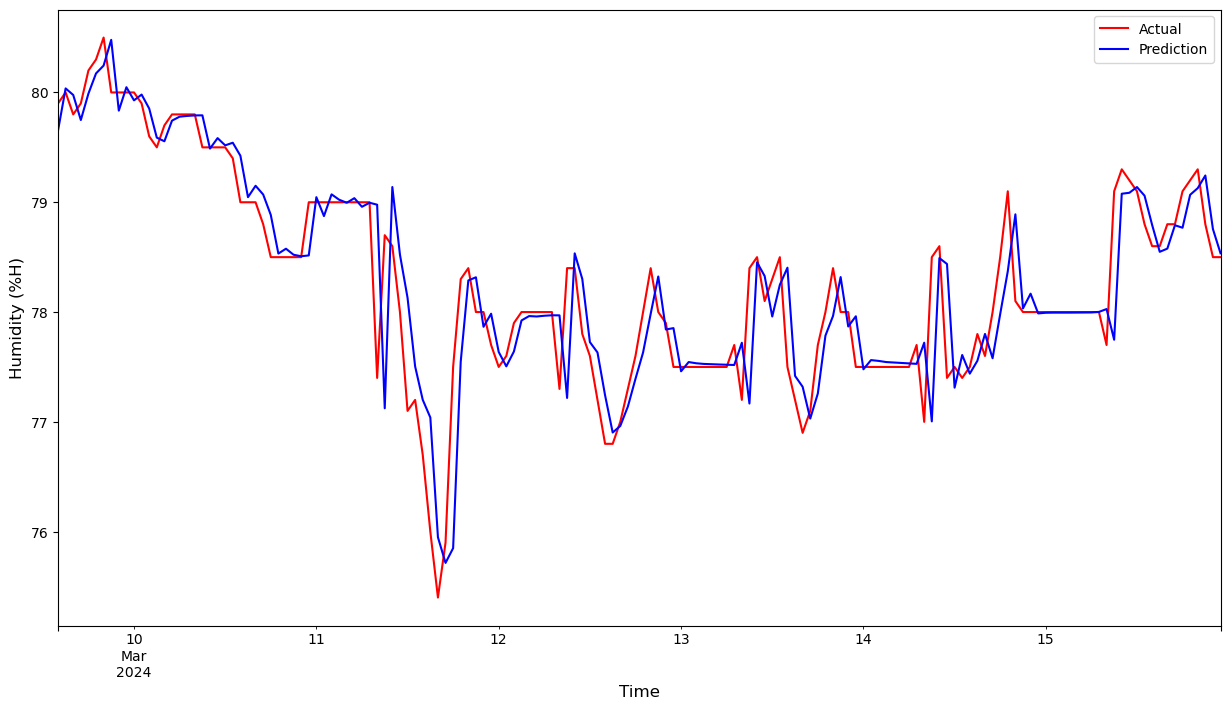

In [46]:
if HORIZON_HUMIDITY == 1:
    eval_df_humidity.plot(x='Time', y=['Actual', 'Prediction'], style=['r', 'b'], figsize=(15, 8))
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Humidity (%H)', fontsize=12)
    plt.legend(['Actual', 'Prediction'], loc='best')
    plt.show()
else:
    plot_df_humidity = eval_df_humidity[(eval_df_humidity.H == 't+1')][['Time', 'Actual']]
    for t in range(1, HORIZON_HUMIDITY + 1):
        plot_df_humidity['t+' + str(t)] = eval_df_humidity[(eval_df_humidity.H == 't+' + str(t))]['Prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    ax.plot(plot_df_humidity['Time'], plot_df_humidity['Actual'], color='red', linewidth=4.0, label='Actual')
    for t in range(1, HORIZON_HUMIDITY + 1):
        x = plot_df_humidity['Time'][(t - 1):]
        y = plot_df_humidity['t+' + str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4 * math.pow(.9, t), alpha=math.pow(0.8, t),
                label='Prediction t+' + str(t))

    ax.legend(loc='best')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Humidity (%H)', fontsize=12)
    plt.show()

In [47]:
next_hour = pd.date_range(start=df.index[-1], periods=2, freq='H')[-1]

In [48]:
pred_humidity = model_fit_humidity.predict(start=len(df), end=len(df), typ="levels")[0]
pred_humidity_nonscaled = round(scaler.inverse_transform(np.array(pred_humidity).reshape(-1, 1))[0][0], 1)
print(f"{next_hour} {pred_humidity_nonscaled}")

2024-03-16 00:00:00 78.7
